In [17]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
from mecab import MeCab
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request


In [18]:
raw = pd.read_csv('./Training/merged_data.csv')
df = raw.copy()

In [19]:
list_index = df[df.summary.duplicated()].index

In [20]:
df.head()

,passage,summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전..."
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...


In [21]:
list_index

Int64Index([   455,   3569,   3570,   3571,   3572,   3573,   3574,   3575,
              3576,  10635,
            ...
            157796, 157797, 158246, 158248, 158249, 158256, 158299, 158301,
            158302, 158303],
           dtype='int64', length=1533)

In [22]:
# 중복된 데이터 처리
for index in list_index:
    df = df.drop(index)

In [23]:
df.isnull().sum()

passage    0
summary    0
dtype: int64

In [24]:
korean_josa_list = [
    '의', '에', '에서', '도', '이', '가', '을', '를',
    '은', '는', '과', '와', '으로', '에게', '부터', '까지',
    '만', '에서부터', '까지'
]

In [25]:

# 불용어(stopwords) 로드
stop_words = set()
with open("./stopwords.txt", 'r', encoding='utf-8') as f:
    for word in f.readlines():
        word = word.strip()
        if word not in korean_josa_list:
            stop_words.add(word)
# 형태소 분석기 초기화
mecab = MeCab()


In [26]:
def preprocess_text(text):
    token = mecab.morphs(text)
    return ' '.join(token)

In [27]:
df['PreprocessedText'] = df['passage'].apply(preprocess_text)

In [28]:
df['Pred_summary'] = df['summary'].apply(preprocess_text)

In [29]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower()  # 텍스트 소문자화
    sentence = re.sub(r"/([^)]*/)", "", sentence)  # 괄호로 닫힌 문자열 제거 Ex) 가나다 (abc) -> 가나다
    sentence = re.sub('"', "", sentence)  # 쌍따옴표 " 제거
    sentence = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣]", " ", sentence)  # 한글과 영어, 숫자를 제외한 문자 공백으로 변환
    sentence = re.sub(" +", " ", sentence)

    # 불용어 제거
    if remove_stopwords:
        sentence = ' '.join(word for word in sentence.split() if word not in stop_words and len(word) > 1)
    else:
        sentence = ' '.join(word for word in sentence.split() if len(word) > 1)
    return sentence

In [30]:
df.head()

,passage,summary,PreprocessedText,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 의 국가 가 직면 하 는 위기 는 전통 사회 의 그것 과 위기 의 규모 뿐 만...,현대 사회 에서 발생 하 는 다양 하 고 복잡 한 위기 는 과거 와 다르 게 국가 ...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 나 불량 수산 식품 파동 등 의 인위 적 재난 이 수산 분야 피해 로 이어...,수산 분야 의 인위 적 재난 시수 산물 수급 문제 로 생산자 들 의 매출 이 크 게...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,하지만 이 와 반 대로 MG 파동 이후 기간 ( 2005 . 10 ～ 2011 . ...,MG 파동 이후 에 는 양식 송어 의 생산량 의 증가 가 통계 적 유의 성 을 갖 ...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,그러나 사회 적 이슈 가 발생 하 였을 경우 에 전문 적 으로 이러 한 정보 를 수...,사회 적 이슈 발생 시 전문 적 으로 정보 수집 및 분석 을 하 는 관측 시스템 이...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,네 번 째 는 공급 감소 로 국내 물량 이 부족 하 게 되 면 유통 질서 가 왜곡 ...,일부 경우 에서 의 유통 질서 혼란 을 방지 하 기 위해 거래 형태 의 변형 이 필...


In [31]:
df['PreprocessedText'] = df['PreprocessedText'].apply(preprocess_sentence)

In [32]:
df.head()

,passage,summary,PreprocessedText,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 에서 사뭇 다르 다고 현...,현대 사회 에서 발생 하 는 다양 하 고 복잡 한 위기 는 과거 와 다르 게 국가 ...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 의 인위 적 재난 시수 산물 수급 문제 로 생산자 들 의 매출 이 크 게...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 으로 나타났 기간 지날수...,MG 파동 이후 에 는 양식 송어 의 생산량 의 증가 가 통계 적 유의 성 을 갖 ...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 으로 이러 정보 수집 분석 관측 시스템 존재 는다고...,사회 적 이슈 발생 시 전문 적 으로 정보 수집 및 분석 을 하 는 관측 시스템 이...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 에서 의 유통 질서 혼란 을 방지 하 기 위해 거래 형태 의 변형 이 필...


In [33]:
df['Pred_summary'] = df['Pred_summary'].apply(preprocess_sentence)

In [34]:
df.rename(columns={'PreprocessedText': 'Pred_Text'}, inplace=True)


In [35]:
df.head()

,passage,summary,Pred_Text,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 에서 사뭇 다르 다고 현...,현대 사회 에서 발생 다양 복잡 위기 과거 다르 국가 재난 으로 이어질 으므로 국가...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 으로 나타났 기간 지날수...,파동 이후 양식 송어 생산량 증가 통계 유의 으로 드러났 통해 파동 이후 양식 송어...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 으로 이러 정보 수집 분석 관측 시스템 존재 는다고...,사회 이슈 발생 전문 으로 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 에서 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시...


In [36]:
df.replace('', np.nan, inplace=True)
print(df.isnull().sum())

passage         0
summary         0
Pred_Text       5
Pred_summary    2
dtype: int64


In [37]:
df.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 158464


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 259
텍스트의 평균 길이 : 95.03571789176091
요약의 최소 길이 : 1
요약의 최대 길이 : 86
요약의 평균 길이 : 27.1804384592084


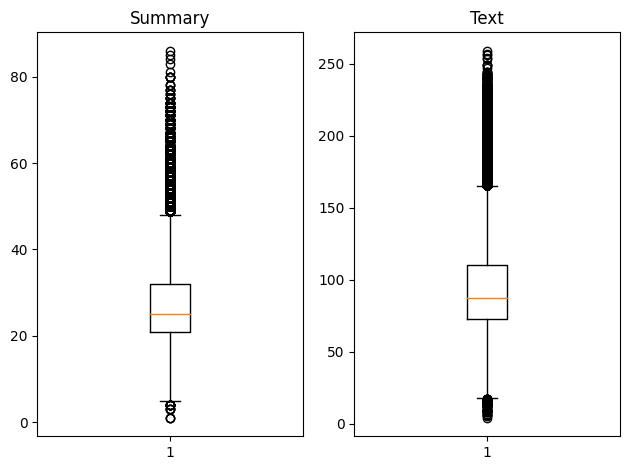

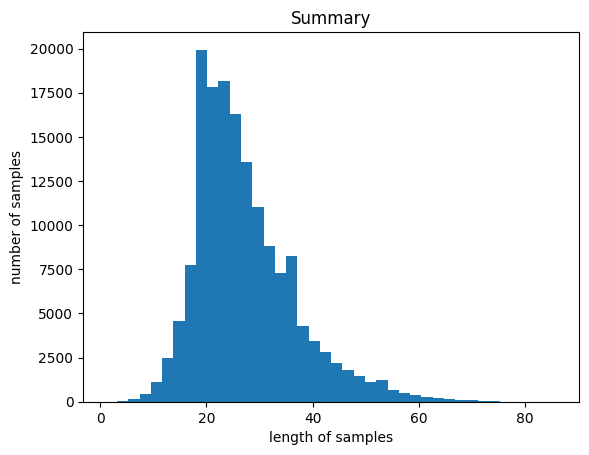

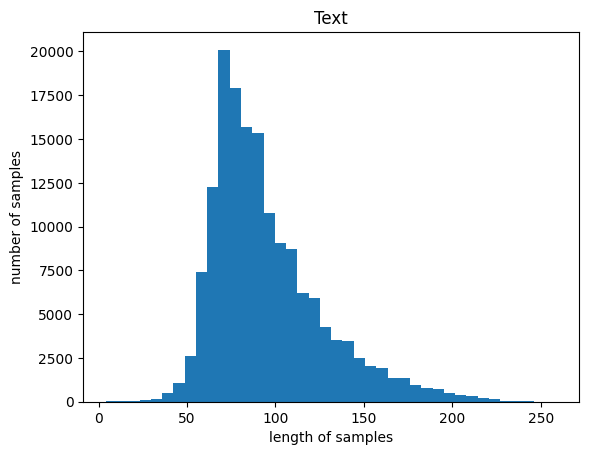

In [38]:
text_len = [len(s.split()) for s in df['Pred_Text']]
summary_len = [len(s.split()) for s in df['Pred_summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [39]:
text_max_len = 160
summary_max_len = 50

In [40]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [41]:
below_threshold_len(text_max_len, df['Pred_Text'])


전체 샘플 중 길이가 160 이하인 샘플의 비율: 0.952266760904685


In [42]:
below_threshold_len(summary_max_len, df['Pred_summary'])


전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9739562298061389


In [43]:
df = df[df['Pred_Text'].apply(lambda x: len(x.split()) <= text_max_len)]
df = df[df['Pred_summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df)))

전체 샘플수 : 149954


In [44]:
df.head()

,passage,summary,Pred_Text,Pred_summary
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 에서 사뭇 다르 다고 현...,현대 사회 에서 발생 다양 복잡 위기 과거 다르 국가 재난 으로 이어질 으므로 국가...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 으로 나타났 기간 지날수...,파동 이후 양식 송어 생산량 증가 통계 유의 으로 드러났 통해 파동 이후 양식 송어...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 으로 이러 정보 수집 분석 관측 시스템 존재 는다고...,사회 이슈 발생 전문 으로 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 에서 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시...


In [45]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
df['decoder_input'] = df['Pred_summary'].apply(lambda x : 'sostoken '+ x)
df['decoder_target'] = df['Pred_summary'].apply(lambda x : x + ' eostoken')
df.head()


,passage,summary,Pred_Text,Pred_summary,decoder_input,decoder_target
0,지금의 국가가 직면하는 위기는 전통사회의 그것과 위기의 규모뿐만아니라 종류와 성질 ...,현대 사회에서 발생하는 다양하고 복잡한 위기는 과거와 다르게 국가의 재난으로 이어질...,지금 국가 직면 위기 전통 사회 그것 위기 규모 종류 성질 에서 사뭇 다르 다고 현...,현대 사회 에서 발생 다양 복잡 위기 과거 다르 국가 재난 으로 이어질 으므로 국가...,sostoken 현대 사회 에서 발생 다양 복잡 위기 과거 다르 국가 재난 으로 이...,현대 사회 에서 발생 다양 복잡 위기 과거 다르 국가 재난 으로 이어질 으므로 국가...
1,자연재해나 불량 수산식품 파동 등의 인위적 재난이 수산분야 피해로이어질 경우 일반분...,"수산분야의 인위적 재난 시수산물 수급 문제로 생산자들의 매출이 크게 줄고, 시장 전...",자연재해 불량 수산 식품 파동 인위 재난 수산 분야 피해 이어질 경우 일반 분야 마...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...,sostoken 수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 ...,수산 분야 인위 재난 시수 산물 수급 문제 생산자 매출 시장 전체 생산자 잉여 감소...
2,하지만 이와 반대로 MG 파동 이후 기간(2005.10～2011.12)의 경우에는 ...,MG 파동 이후에는 양식 송어의 생산량의 증가가 통계적 유의성을 갖는 것으로 드러났...,대로 파동 이후 기간 경우 모형 적합 변수 통계 유의 존재 으로 나타났 기간 지날수...,파동 이후 양식 송어 생산량 증가 통계 유의 으로 드러났 통해 파동 이후 양식 송어...,sostoken 파동 이후 양식 송어 생산량 증가 통계 유의 으로 드러났 통해 파동...,파동 이후 양식 송어 생산량 증가 통계 유의 으로 드러났 통해 파동 이후 양식 송어...
3,그러나 사회적 이슈가 발생하였을 경우에 전문적으로 이러한 정보를 수집하고 분석하는 ...,사회적 이슈 발생 시 전문적으로 정보 수집 및 분석을 하는 관측 시스템이 아직 구축...,사회 이슈 발생 였을 경우 전문 으로 이러 정보 수집 분석 관측 시스템 존재 는다고...,사회 이슈 발생 전문 으로 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 ...,sostoken 사회 이슈 발생 전문 으로 정보 수집 분석 관측 시스템 아직 구축 ...,사회 이슈 발생 전문 으로 정보 수집 분석 관측 시스템 아직 구축 정확 관측 단기 ...
4,네 번째는 공급감소로 국내 물량이 부족하게 되면 유통질서가 왜곡될 가능성이 많기 때...,일부 경우에서의 유통질서 혼란을 방지하기 위해 거래형태의 변형이 필요하다. 의도적 ...,공급 감소 국내 물량 부족 유통 질서 왜곡 가능 때문 직거래 특판 개설 거래 형태 ...,일부 경우 에서 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시...,sostoken 일부 경우 에서 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의...,일부 경우 에서 유통 질서 혼란 방지 위해 거래 형태 변형 필요 의도 물량 창출 시...


In [46]:
encoder_input = np.array(df['Pred_Text'])
decoder_input = np.array(df['decoder_input'])
decoder_target = np.array(df['decoder_target'])


In [47]:
import random

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)


[  8675 133031 111230 ...  97878  24586  26477]


In [48]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 29990


In [49]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [50]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 119964
훈련 레이블의 개수 : 119964
테스트 데이터의 개수 : 29990
테스트 레이블의 개수 : 29990


In [51]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [52]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 82923
등장 빈도가 6번 이하인 희귀 단어의 수: 54035
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 28888
단어 집합에서 희귀 단어의 비율: 65.16286193215393
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0752961906954506


In [53]:
src_vocab = 29000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [54]:
print(encoder_input_train[:3])


[[587, 17, 1306, 434, 498, 8, 484, 434, 133, 1056, 2180, 2, 9516, 638, 44, 1004, 8, 2, 186, 57, 1243, 434, 71, 5330, 185, 3365, 4024, 590, 8, 691, 411, 434, 634, 47, 871, 1011, 299, 434, 59, 32, 17, 590, 1, 1286, 5, 17, 21, 434, 77, 71, 1484, 5, 4925, 3060, 277, 253, 848, 69, 198, 908, 384, 156, 17, 83, 190, 282, 33], [3365, 3946, 1136, 618, 5654, 4024, 590, 1136, 78, 364, 2369, 5, 138, 78, 820, 1940, 219, 227, 219, 1931, 706, 23, 71, 22, 21, 706, 23, 71, 5, 1940, 219, 93, 227, 219, 2376, 1437, 1417, 41, 45, 162, 165, 2376, 4447, 219, 22, 820, 515, 5, 1940, 219, 5, 31, 45, 281, 1252, 66, 515, 4447, 219, 22, 1136, 618, 5654, 227, 219, 5, 515, 4447, 219, 2376, 4447, 609, 162, 1, 8, 2571, 219, 28, 891, 22], [1035, 5654, 89, 174, 5, 351, 650, 391, 322, 850, 218, 1, 143, 174, 8612, 1144, 20641, 1940, 850, 1, 64, 1, 25, 21, 25, 28, 475, 1, 5, 1144, 20641, 1940, 60, 5654, 305, 174, 89, 174, 1, 184, 376, 1, 15, 1220, 419, 5654, 1940, 636, 184, 5654, 89, 1144, 20641, 1940, 305, 184, 219, 1, 143

In [55]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)


In [56]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


단어 집합(vocabulary)의 크기 : 48237
등장 빈도가 5번 이하인 희귀 단어의 수: 32315
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 15922
단어 집합에서 희귀 단어의 비율: 66.99214296079774
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8618710223097295


In [57]:
tar_vocab = 16000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)


In [58]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)


In [59]:
print(decoder_input_train[:5])


[[2, 905, 10, 4, 78, 47, 830, 369, 581, 396, 20, 497, 1, 2325, 430, 20, 1197, 523, 144, 8], [2, 1029, 79, 3858, 497, 4186, 3896, 660, 19, 2246, 1312, 42, 266, 2246, 3717, 163, 217, 42, 263, 1281, 13, 179, 460, 3717, 163, 29], [2, 5138, 85, 1114, 1827, 51, 349, 1198, 1, 2636, 26, 5138, 85, 1114, 102, 3507, 685, 2689], [2, 10, 721, 78, 181, 1, 34, 586, 30, 1889, 104, 719, 155, 772, 1889, 957, 523, 309, 431], [2, 361, 24, 4, 724, 888, 1357, 526, 12, 357, 212, 1968, 8, 1014, 1795, 422, 42, 1750, 6853, 710, 1592, 8]]


In [60]:
print(decoder_target_train[:5])


[[905, 10, 4, 78, 47, 830, 369, 581, 396, 20, 497, 1, 2325, 430, 20, 1197, 523, 144, 8, 3], [1029, 79, 3858, 497, 4186, 3896, 660, 19, 2246, 1312, 42, 266, 2246, 3717, 163, 217, 42, 263, 1281, 13, 179, 460, 3717, 163, 29, 3], [5138, 85, 1114, 1827, 51, 349, 1198, 1, 2636, 26, 5138, 85, 1114, 102, 3507, 685, 2689, 3], [10, 721, 78, 181, 1, 34, 586, 30, 1889, 104, 719, 155, 772, 1889, 957, 523, 309, 431, 3], [361, 24, 4, 724, 888, 1357, 526, 12, 357, 212, 1968, 8, 1014, 1795, 422, 42, 1750, 6853, 710, 1592, 8, 3]]


In [61]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]


In [62]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))


삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0


In [63]:
# encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
# decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
# decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

# encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
# decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
# decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

# print('훈련 데이터의 개수 :', len(encoder_input_train))
# print('훈련 레이블의 개수 :',len(decoder_input_train))
# print('테스트 데이터의 개수 :',len(encoder_input_test))
# print('테스트 레이블의 개수 :',len(decoder_input_test))


In [64]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')


In [65]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [66]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


In [67]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])


In [68]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 160, 128)     3712000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 160, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [69]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/20.%20Text%20Summarization%20with%20Attention/attention.py", filename="attention.py")
from attention import AttentionLayer


In [70]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 160, 128)     3712000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 160, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In [71]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, callbacks=[es], epochs = 30)


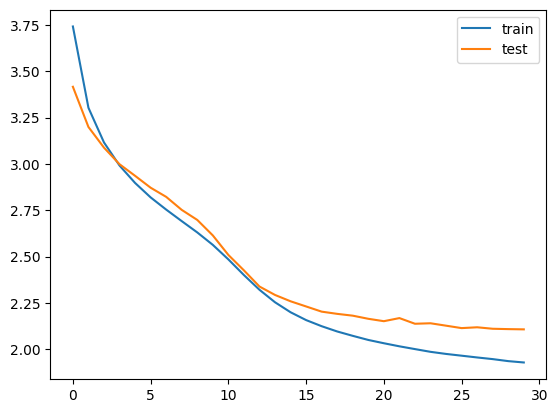

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


 seq2seq + attention으로 요약 모델 테스트하기

In [ ]:
import tensorflow as tf

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # 가중치 행렬을 정의하고 Xavier 초기화(Xavier/Glorot initialization)를 적용합니다.
        self.W_q = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                   initializer='glorot_uniform',
                                   trainable=True,
                                   name='query_weight')
        self.W_k = self.add_weight(shape=(input_shape[-1], input_shape[-1]),
                                   initializer='glorot_uniform',
                                   trainable=True,
                                   name='key_weight')
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # 쿼리(Query)와 키(Key)를 계산합니다.
        query = tf.matmul(inputs, self.W_q)
        key = tf.matmul(inputs, self.W_k)

        # 유사도를 계산합니다. 여기에서는 내적(dot product)을 사용합니다.
        similarity = tf.matmul(query, key, transpose_b=True)

        # 유사도를 스케일링합니다. (예: 루트 단위로 나눠줍니다)
        d_k = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_similarity = similarity / tf.math.sqrt(d_k)

        # softmax를 적용하여 가중치를 계산합니다.
        weights = tf.nn.softmax(scaled_similarity, axis=-1)

        # 가중합을 계산하여 어텐션 출력을 구합니다.
        output = tf.matmul(weights, inputs)

        return output


In [ ]:
import tensorflow as tf

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # 어텐션 레이어의 가중치를 정의하고 초기화합니다 (만약 필요하다면)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # 어텐션 메커니즘을 구현합니다
        # 예를 들어, 점곱 어텐션(dot-product attention)을 사용하거나 다른 어텐션 메커니즘을 적용할 수 있습니다
        return attention_result


In [ ]:
from tensorflow.keras.models import load_model

# 모델을 로드하기 전에 AttentionLayer 클래스를 정의합니다
class AttentionLayer(tf.keras.layers.Layer):
    # 어텐션 레이어의 구현 내용을 작성합니다

# 커스텀 어텐션 레이어를 사용하여 모델을 로드합니다
# model_path = "./model2.h5"
model = load_model("./model2.h5", custom_objects={'AttentionLayer': AttentionLayer})


IndentationError: expected an indented block (15018678.py, line 9)

In [77]:
model = load_model('./model2.h5',custom_objects={'AttentionLayer':AttentionLayer})

In [73]:
model = keras.models.load_model('./model2.h5')

NameError: name 'keras' is not defined

In [92]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [76]:
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model,show_shapes=True).create(prog='dot',format='svg'))

ImportError: cannot import name 'wrappers' from 'tensorflow.python.keras.layers' (c:\Users\User\anaconda3\envs\hee\lib\site-packages\tensorflow\python\keras\layers\__init__.py)

In [74]:
# 0. 사용할 패키지 불러오기
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
import numpy as np
from numpy import argmax

# 1. 실무에 사용할 데이터 준비하기
(x_train,y_train),(x_test,y_test)=mnist.load_data()
x_test = x_test.reshape(10000,784).astype('float32') / 255.0
y_test = np_utils.to_categorical(y_test)
xhat_idx = np.random.choice(x_test.shape[0],5)
xhat = x_test[xhat_idx]

# 2. Model 불러오기
from tensorflow.python.keras.models import load_model
model = load_model('model2.h5')

ModuleNotFoundError: No module named 'tensorflow.python.keras.datasets'

In [75]:
# 0. 사용할 패키지 불러오기
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
import numpy as np

# 1. 실무에 사용할 데이터 준비하기
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
y_test = to_categorical(y_test)
xhat_idx = np.random.choice(x_test.shape[0], 5)
xhat = x_test[xhat_idx]

# 2. Model 불러오기
model = load_model('model2.h5')


ValueError: Unknown layer: AttentionLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# CuDNN 활성화를 위해 TensorFlow 백엔드 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
    except RuntimeError as e:
        print(e)

# 모델 불러오기
model_path = "C:/Users/User/Downloads/도서자료 요약/model2.h5"
model = load_model(model_path,custom)

Physical devices cannot be modified after being initialized


ValueError: Unknown layer: AttentionLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [78]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [79]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])


In [80]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [81]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [82]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence


In [83]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence=''
    for i in input_seq:
        if(i!=0):
            sentence = sentence + src_index_to_word[i]+' '
    return sentence

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence


In [85]:
for i in range(0, 10):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")


원문 :  특히 평화 정착 위해 국정 과제 제시 한반도 평화 체제 구축 방안 적극 으로 추진 으로 보인다 문재인 정부 비핵화 진전 평화 체제 협상 추진 완전 해결 단계 에서 평화 협정 체결 평화 체제 진전 시키 구상 제시 위해 평화 체제 구축 로드맵 마련 비핵화 합의 목표 부터 동결 에서 완전 폐기 이어지 포괄 비핵화 협상 방안 마련 비핵화 초기 조치 확보 포괄 비핵화 협상 재개 추진 전망 북한 확고 무장 의지 협상 거부 입장 한국 평화 체제 구축 구상 대한 미국 이해 지지 미비 평화 체제 구축 위한 자회 실패 경험 으로 인해 단시간 비핵화 평화 체제 구축 위한 노력 성과 거둘 가능 매우 투명 
실제 요약문 : 문재인 정부 한반도 평화 체제 구축 방안 제시 였으나 북한 흔들림 무장 의지 협상 거부 미국 이해 협조 미비 으로 단시간 비핵화 평화 체제 구축 어렵 
1/1 [==============================] - 0s 17ms/step
예측 요약문 :  북한 에서 에서 에서 에서 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로


원문 :  셋째 한국 정부 문제 해결 위해 제재 대화 병행 추진 전망 지난 추진 전략 인내 정책 으로부터 방향 선회 의미 한다 정부 대북 제재 압박 정책 추진 면서 목표 분명 북한 붕괴 목표 라는 해석 현재 정부 대북 제재 압박 목표 북한 붕괴 비핵화 진전 협상 재개 명료히 최근 정부 공동 으로 북한 정권 교체 정권 붕괴 통일 가속 흡수 통일 이북 으로 침공 는다는 소위 정책 기조 반복 대화 장애 요인 제거 고자 강한 의지 보이 으로 해석 된다 
실제 요약문 : 지난 한미 정부 추진 북한 대한 전략 인내 정책 목표 분명 현재 정부 비핵화 진전 협상 재개 목표 분명히 정책 기조 반복 그렇 
1/1 [==============================] - 0s 19ms/step
예측 요약문 :  북한 에서 에서 에서 에서 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로 으로


원문 

In [87]:
from rouge import Rouge

In [88]:
rouge = Rouge()
reference_summary = seq2summary(decoder_input_test[0])
predicted_summary = decode_sequence(encoder_input_test[0].reshape(1, text_max_len))
scores = rouge.get_scores(predicted_summary, reference_summary, avg=True)
print("rouge scores: ", scores)

# bleu score 출력
from nltk.translate.bleu_score import sentence_bleu

reference = [reference_summary.split()]
candidate = predicted_summary.split()
bleu_score = sentence_bleu(reference, candidate)
print("bleu score: ", bleu_score)

1/1 [==============================] - 0s 21ms/step
rouge scores:  {'rouge-1': {'r': 0.08695652173913043, 'p': 0.6666666666666666, 'f': 0.15384615180473374}, 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0}, 'rouge-l': {'r': 0.08695652173913043, 'p': 0.6666666666666666, 'f': 0.15384615180473374}}
bleu score:  6.283953809295883e-232


c:\Users\User\anaconda3\envs\hee\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\User\anaconda3\envs\hee\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\User\anaconda3\envs\hee\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoo

In [ ]:
model.save('model2.h5')

In [ ]:
!pip install rouge

In [ ]:
from rouge import  Rouge

In [ ]:
rouge = Rouge()

In [ ]:
rouge.get_scores()

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu

def calculate_bleu_scores(reference, candidate):
    reference_tokens = [reference.split()]
    candidate_tokens = candidate.split()

    # Calculate BLEU score with 4-gram (BLEU-4)
    bleu_score = sentence_bleu(reference_tokens, candidate_tokens, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu_score

# seq2text(), seq2summary(), decode_sequence() 함수가 이미 정의되어 있다고 가정합니다.

# 예시 사용:
reference_summary = seq2summary(decoder_input_test[0])
predicted_summary = decode_sequence(encoder_input_test[0].reshape(1, text_max_len))

print("원문: ", seq2text(encoder_input_test[0]))
print("실제 요약문: ", reference_summary)
print("예측 요약문: ", predicted_summary)

bleu_score = calculate_bleu_scores(reference_summary, predicted_summary)
print("BLEU 점수: ", bleu_score)

print('실습 코드의 BLEU :',bleu_score(candidate.split(),list(map(lambda ref: ref.split(), references))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

In [ ]:
print("원문 : ",seq2text(encoder_input_test[0]))
print("실제 요약문 :",seq2summary(decoder_input_test[0]))
print("예측 요약문 :",decode_sequence(encoder_input_test[0].reshape(1, text_max_len)))
print("rouge scores: ",rouge.get_scores(decode_sequence(encoder_input_test[0].reshape(1, text_max_len)), seq2summary(decoder_input_test[0]) , avg= True))

원문 :  특히 평화 정착 위해 국정 과제 제시 한반도 평화 체제 구축 방안 적극 으로 추진 으로 보인다 문재인 정부 비핵화 진전 평화 체제 협상 추진 완전 해결 단계 에서 평화 협정 체결 평화 체제 진전 시키 구상 제시 위해 평화 체제 구축 로드맵 마련 비핵화 합의 목표 부터 동결 에서 완전 폐기 이어지 포괄 비핵화 협상 방안 마련 비핵화 초기 조치 확보 포괄 비핵화 협상 재개 추진 전망 북한 확고 무장 의지 협상 거부 입장 한국 평화 체제 구축 구상 대한 미국 이해 지지 미비 평화 체제 구축 위한 자회 실패 경험 으로 인해 단시간 비핵화 평화 체제 구축 위한 노력 성과 거둘 가능 매우 투명 
실제 요약문 : 문재인 정부 한반도 평화 체제 구축 방안 제시 였으나 북한 흔들림 무장 의지 협상 거부 미국 이해 협조 미비 으로 단시간 비핵화 평화 체제 구축 어렵 
1/1 [==============================] - 0s 20ms/step
예측 요약문 :  평화 정착 위해 국정 과제 제시 남북 체제 구축 방안 추진 으로 보인다 평화 체제 구축 로드맵 마련 비핵화 협상 방안 마련 비핵화 협상 협상 거부 입장 한국 평화 체제 구축 구상
1/1 [==============================] - 0s 23ms/step
rouge scores:  {'rouge-1': {'r': 0.391304347826087, 'p': 0.42857142857142855, 'f': 0.4090909041012397}, 'rouge-2': {'r': 0.17391304347826086, 'p': 0.15384615384615385, 'f': 0.1632653011411913}, 'rouge-l': {'r': 0.2608695652173913, 'p': 0.2857142857142857, 'f': 0.27272726773760336}}


In [ ]:
print("원문 : ",seq2text(encoder_input_test[1]))
print("실제 요약문 :",seq2summary(decoder_input_test[1]))
print("예측 요약문 :",decode_sequence(encoder_input_test[1].reshape(1, text_max_len)))
print("rouge scores: ",rouge.get_scores(decode_sequence(encoder_input_test[1].reshape(1, text_max_len)), seq2summary(decoder_input_test[1]) , avg= True))

원문 :  셋째 한국 정부 문제 해결 위해 제재 대화 병행 추진 전망 지난 추진 전략 인내 정책 으로부터 방향 선회 의미 한다 정부 대북 제재 압박 정책 추진 면서 목표 분명 북한 붕괴 목표 라는 해석 현재 정부 대북 제재 압박 목표 북한 붕괴 비핵화 진전 협상 재개 명료히 최근 정부 공동 으로 북한 정권 교체 정권 붕괴 통일 가속 흡수 통일 이북 으로 침공 는다는 소위 정책 기조 반복 대화 장애 요인 제거 고자 강한 의지 보이 으로 해석 된다 
실제 요약문 : 지난 한미 정부 추진 북한 대한 전략 인내 정책 목표 분명 현재 정부 비핵화 진전 협상 재개 목표 분명히 정책 기조 반복 그렇 
1/1 [==============================] - 0s 22ms/step
예측 요약문 :  한국 정부 문제 해결 위해 제재 대화 병행 추진 전망 지난 추진 전략 인내 정책 기조 반복 대화 장애 요인 제거 고자 강한 의지 보이
1/1 [==============================] - 0s 25ms/step
rouge scores:  {'rouge-1': {'r': 0.4, 'p': 0.34782608695652173, 'f': 0.37209301828015146}, 'rouge-2': {'r': 0.18181818181818182, 'p': 0.16666666666666666, 'f': 0.1739130384877128}, 'rouge-l': {'r': 0.35, 'p': 0.30434782608695654, 'f': 0.32558139037317474}}


In [89]:
import nltk.translate.bleu_score as bleu
print('실습 코드의 BLEU :',bleu_score(decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).split(),list(map(lambda ref: ref.split(), seq2text(encoder_input_test[i])))))
print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),decode_sequence(encoder_input_test[i].reshape(1, text_max_len)).split()))

1/1 [==============================] - 0s 14ms/step


TypeError: 'float' object is not callable

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 160, 128)     3712000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 160, 256),   394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            